# Examples for the code in SuperconductingSample.py

The code in SuperconductingSample.py is intended to be a collection of common data treatment functions applied to measured data on superconducting samples.
While the theory of superconductors is in Physics.py, this file focuses on the extraction of results from experimental data.


In [1]:
from SuperconductingSample import NIS
from NanonisMeasurement import NanBiasSpectroscopy

## Load the Bias Spectrosocpy

This is known from NanonisMeasurement. We just need to load some data to work with.

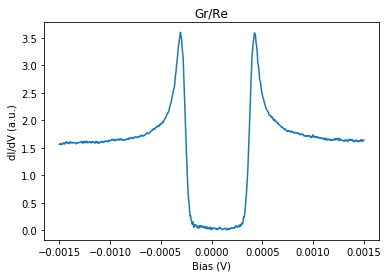

In [2]:
BS = NanBiasSpectroscopy('Example-Data/BiasSpectroscopyNIS.dat',title='Gr/Re')
BS_dIdV = BS.get_dIdV()
BS_dIdV.plot_standalone()

## quick analysis

### get the coherence peaks

In [3]:
# format of the result:
# [[x1,y1],
#  [x2,y2]]
NIS.get_coherence_peaks(BS_dIdV)

[[-0.0003063063063063064, 3.5999538529879516],
 [0.0004234234234234234, 3.5911309419252517]]

Clearly, the peaks are not symmetric around 0 (see first column); This is caused by a bias offset. Let's correct it

### correct bias offset

In [19]:
BS_dIdV = NIS.correct_bias_offset(BS_dIdV)  # correct the bias offset

NIS.get_coherence_peaks(BS_dIdV)            # and lets check the result

[[-0.00036469369369369377, 3.5996776033811444],
 [0.00036469369369369377, 3.590419789481754]]

### superconducting gap estimation
Estimate the gap from the distance of the two coherence peaks

In [5]:
print(f'The gap is approximately: {NIS.get_gap_estimate(BS_dIdV)*1e6:.0f}µeV')

The gap is approximately: 365µeV


Note that this generally **overestimates** the real gap value!

### scale the spectrum to a normal state conductance of 1

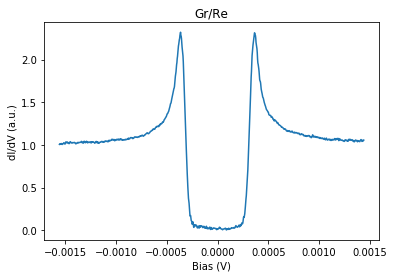

In [20]:
BS_dIdV = (1/NIS.get_normal_state_conductance(BS_dIdV))*BS_dIdV
BS_dIdV.plot_standalone()

### Coherence peak height
Extract how much higher is the peak than the normal state conductance? (e.g. useful for benchmarking the tip quality on Pb)

In [7]:
NIS.get_peak_increase(BS_dIdV)

2.317692630482095

## fitting the BCS DOS
Let us now turn to fitting the spectra with a BCS DOS (including a Dynes parameter).

In [8]:
import matplotlib.pyplot as plt

#### effective temperature fit

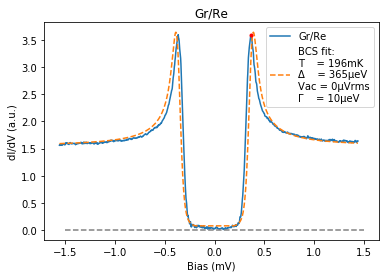

In [9]:
### Let us first fit the effective temperature, using Delta estimated from the peak positions
BS = NanBiasSpectroscopy('Example-Data/BiasSpectroscopyNIS.dat',title='Gr/Re')
BS_dIdV = NIS.correct_bias_offset(BS.get_dIdV(x_unit='mV'))
fit = NIS.fit_T(BS_dIdV,V_ac_rms=15e-6,Gamma=10e-6)

fig, ax = fit.plot()
# you can keep plotting if you want. lets put a dot on the coherence peak of the data
ax.plot(*NIS.get_coherence_peaks(BS_dIdV)[1],'r.')
ax.plot([-1.5,1.5],[0,0],'--',color='grey')

In [10]:
print(f'The estimated effective temperature is {fit.T*1e3:.0f} +- {fit.T_err*1e3:.0f}mK')
T = fit.T

The estimated effective temperature is 196 +- 6mK


#### gap and zero state conductance fit

(<matplotlib.figure.Figure at 0x1deebf2fda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1deec1ef6a0>)

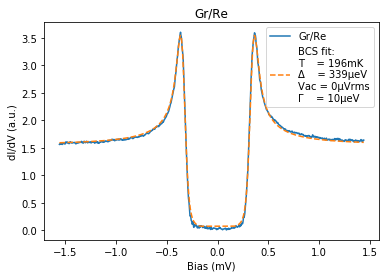

In [11]:
# If we want to fix the temperature and Gamma and just keep Delta and 
# the normal state conductance as free parameters, we can use the fit_Delta_sigma method
BS = NanBiasSpectroscopy('Example-Data/BiasSpectroscopyNIS.dat',title='Gr/Re')
BS_dIdV = NIS.correct_bias_offset(BS.get_dIdV(x_unit='mV'))

fit = NIS.fit_Delta_sigma(BS_dIdV,T=T,V_ac_rms=15e-6,Gamma=10e-6)

fit.plot()

#### gap fit

We can also just fit Delta and define all other parameters manually:

(<matplotlib.figure.Figure at 0x1deec30b198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1deec35fef0>)

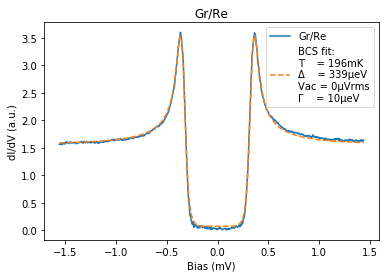

In [12]:
BS = NanBiasSpectroscopy('Example-Data/BiasSpectroscopyNIS.dat',title='Gr/Re')
BS_dIdV = NIS.correct_bias_offset(BS.get_dIdV())                    # x_unit not provided -> work in V

fit = NIS.fit_Delta(BS_dIdV,T=196e-3,sig0=1.55,V_ac_rms=15e-6,Gamma=10e-6)

fit.plot(x_unit='mV')                                               # but plot in mV

#### fit with all parameters free

Finally, we can also keep all four parameters free. However, this does not always give reasonable results.

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(<matplotlib.figure.Figure at 0x1deeb2cbc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1deec1ff518>)

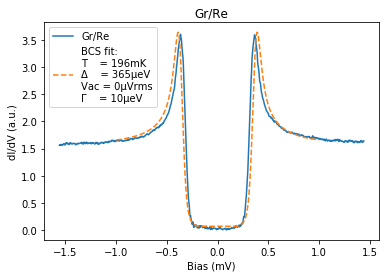

In [13]:
BS = NanBiasSpectroscopy('Example-Data/BiasSpectroscopyNIS.dat',title='Gr/Re')
BS_dIdV = NIS.correct_bias_offset(BS.get_dIdV(x_unit='mV'))

fit = NIS.fit(BS_dIdV,T_guess=196e-3,sig0_guess=1.55,V_ac_rms=15e-6,Gamma_guess=10e-6,x_range=(-1,1))


# lets plot the fit only on user defined bias voltages
import numpy as np
x = np.linspace(-1e-3,1e-3,2001)    # x is always in V!
fit.plot()##(x=x)   # since we do not provide x_unit, the plot is in the x units of the spectrum (BS_dIdV), which here is mV

(<matplotlib.figure.Figure at 0x1deec02edd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1deeb493b00>)

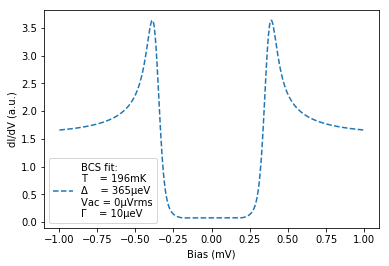

In [14]:
# plot the fit without the experimental data. 
# Note: since we do not provide x, it takes the x values of the experimental data and also keeps its unit!
fit.plot(plot_spectrum=False) 

(<matplotlib.figure.Figure at 0x1deec0c4668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1deebf4b630>)

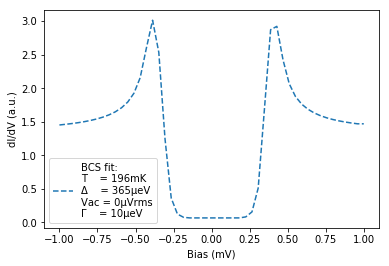

In [15]:
# However, if we provide x, it is always in V!
x = np.linspace(-1e-3,1e-3)
fit.plot(x=x,plot_spectrum=False) 

#### add the fit plot to an exisiting plot

(None, <matplotlib.axes._subplots.AxesSubplot at 0x1deec07c780>)

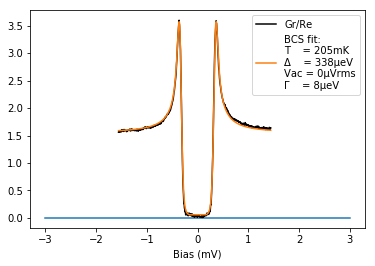

In [18]:
BS = NanBiasSpectroscopy('Example-Data/BiasSpectroscopyNIS.dat',title='Gr/Re')
BS_dIdV = NIS.correct_bias_offset(BS.get_dIdV())

fig, ax = plt.subplots()

ax.set_xlabel('Bias (mV)')
ax.plot([-3,3],[0,0])

fit = NIS.fit(BS_dIdV,T_guess=196e-3,sig0_guess=1.55,V_ac_rms=15e-6,Gamma_guess=10e-6,x_range=(-1,1))
fit.plot(ax=ax,x_unit='mV',fit_plot_args={'color':'tab:orange'},spectrum_plot_args={'color':'k'})
